In [1]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

In [2]:
from transpile_benchy.interfaces.qiskit_interface import (
    QiskitCircuitInterface,
    QuantumCircuitFactory,
)

num_qubits = [8, 12, 16]

from qiskit.circuit.library import TwoLocal


def full_two_local(n):
    return TwoLocal(n, "ry", "cz", entanglement="full", reps=3)


def linear_two_local(n):
    return TwoLocal(n, "ry", "cz", entanglement="linear", reps=3)

In [3]:
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary.from_submodules(
    [
        QuantumCircuitFactory(full_two_local, num_qubits),
        QuantumCircuitFactory(full_two_local, num_qubits),
    ]
)

In [4]:
QuantumCircuitFactory(full_two_local, num_qubits)._get_all_circuits()

['full_two_local_n8', 'full_two_local_n12', 'full_two_local_n16']

In [5]:
from transpile_benchy.metrics.gate_counts import DepthMetric, TotalMetric

depth_metric = DepthMetric(consolidate=False)
total_metric = TotalMetric(consolidate=False)

In [6]:
from transpile_benchy.passmanagers.qiskit_baseline import QiskitBaseline
from qiskit.transpiler import CouplingMap

heavy_hex = CouplingMap.from_heavy_hex(5)
square_lattice = CouplingMap.from_grid(7, 7)

baseline_sq = QiskitBaseline(optimization_level=3, coupling_map=square_lattice)
baseline_hh = QiskitBaseline(optimization_level=3, coupling_map=heavy_hex)

# FIXME, we don't have a way of distinguishing between these transpilers w/o a name
baseline_sq.name = "square_lattice"
baseline_hh.name = "heavy_hex"

In [7]:
benchmark = Benchmark(
    transpilers=[
        baseline_sq,
        baseline_hh,
    ],
    metrics=[depth_metric, total_metric],
    circuit_library=lib,
    logger=transpile_benchy_logger,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...


Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | cx
  0.00% =    0/1    	 | 2.00	 | cx.cx
100.00% =    1/1    	 | 3.00	 | cx.cx.cx


Circuits from library:   0%|          | 0/6 [00:00<?, ?it/s]INFO:transpile_benchy:Running benchmark for circuit full_two_local_n8


Loading full_two_local_n8 from QuantumCircuitFactory


Circuits from library:  17%|█▋        | 1/6 [00:01<00:07,  1.51s/it]INFO:transpile_benchy:Running benchmark for circuit full_two_local_n12


Loading full_two_local_n12 from QuantumCircuitFactory


Circuits from library:  33%|███▎      | 2/6 [00:04<00:09,  2.45s/it]INFO:transpile_benchy:Running benchmark for circuit full_two_local_n16


Loading full_two_local_n16 from QuantumCircuitFactory


Circuits from library:  50%|█████     | 3/6 [00:12<00:14,  4.74s/it]INFO:transpile_benchy:Running benchmark for circuit full_two_local_n8


Loading full_two_local_n8 from QuantumCircuitFactory


Circuits from library:  67%|██████▋   | 4/6 [00:14<00:07,  3.70s/it]INFO:transpile_benchy:Running benchmark for circuit full_two_local_n12


Loading full_two_local_n12 from QuantumCircuitFactory


Circuits from library:  83%|████████▎ | 5/6 [00:20<00:04,  4.52s/it]INFO:transpile_benchy:Running benchmark for circuit full_two_local_n16


Loading full_two_local_n16 from QuantumCircuitFactory


Circuits from library: 100%|██████████| 6/6 [00:26<00:00,  4.36s/it]


In [8]:
print(benchmark)


Transpiler: heavy_hex

  Metric: monodromy_depth
  Circuit: full_two_local_n12                       Mean result: 287.279                        Trials: [295.0, 345.0, 352.0, 209.0, 273.0, 275.0]
  Circuit: full_two_local_n16                       Mean result: 463.200                        Trials: [501.0, 368.0, 520.0, 494.0, 532.0, 392.0]
  Circuit: full_two_local_n8                        Mean result: 179.256                        Trials: [174.0, 183.0, 184.0, 171.0, 185.0, 179.0]

  Metric: monodromy_total
  Circuit: full_two_local_n12                       Mean result: 715.763                        Trials: [723.0, 712.0, 722.0, 638.0, 716.0, 792.0]
  Circuit: full_two_local_n16                       Mean result: 1397.345                       Trials: [1422.0, 1360.0, 1451.0, 1446.0, 1361.0, 1348.0]
  Circuit: full_two_local_n8                        Mean result: 284.295                        Trials: [292.0, 288.0, 279.0, 285.0, 283.0, 279.0]

  Metric: total_runtime
  Circuit:

In [9]:
benchmark.summary_statistics(baseline_sq, baseline_hh)

{'monodromy_depth': {'average_change': 29.19339701205634,
  'aggregrate_change': 29.8484132031093,
  'best_circuit': 'full_two_local_n8',
  'worst_circuit': 'full_two_local_n12'},
 'monodromy_total': {'average_change': 52.42864827497721,
  'aggregrate_change': 53.66440625746868,
  'best_circuit': 'full_two_local_n8',
  'worst_circuit': 'full_two_local_n16'},
 'total_runtime': {'average_change': 20.631820109938687,
  'aggregrate_change': 20.87075476921643,
  'best_circuit': 'full_two_local_n12',
  'worst_circuit': 'full_two_local_n16'}}

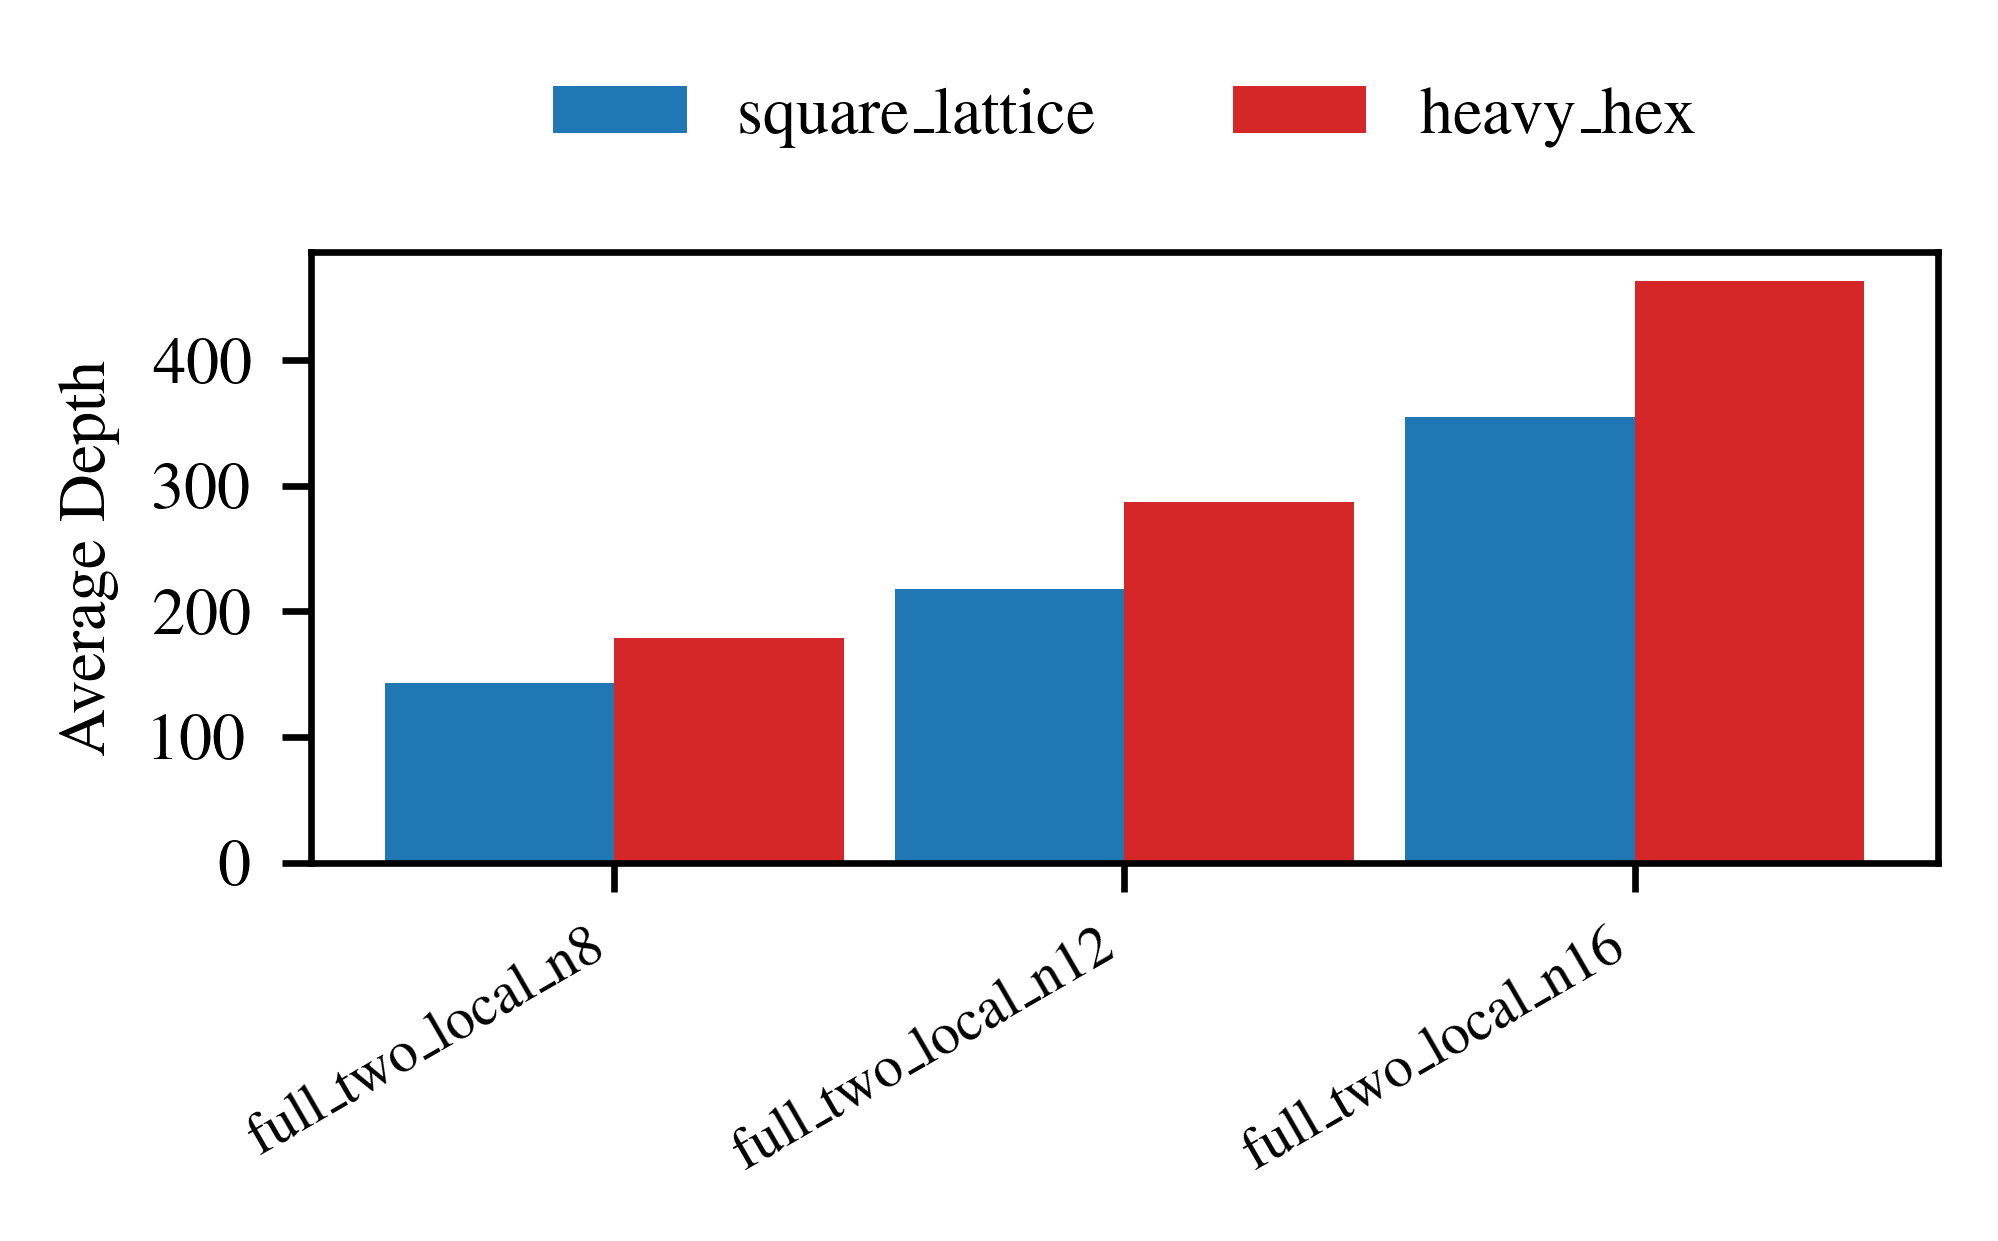

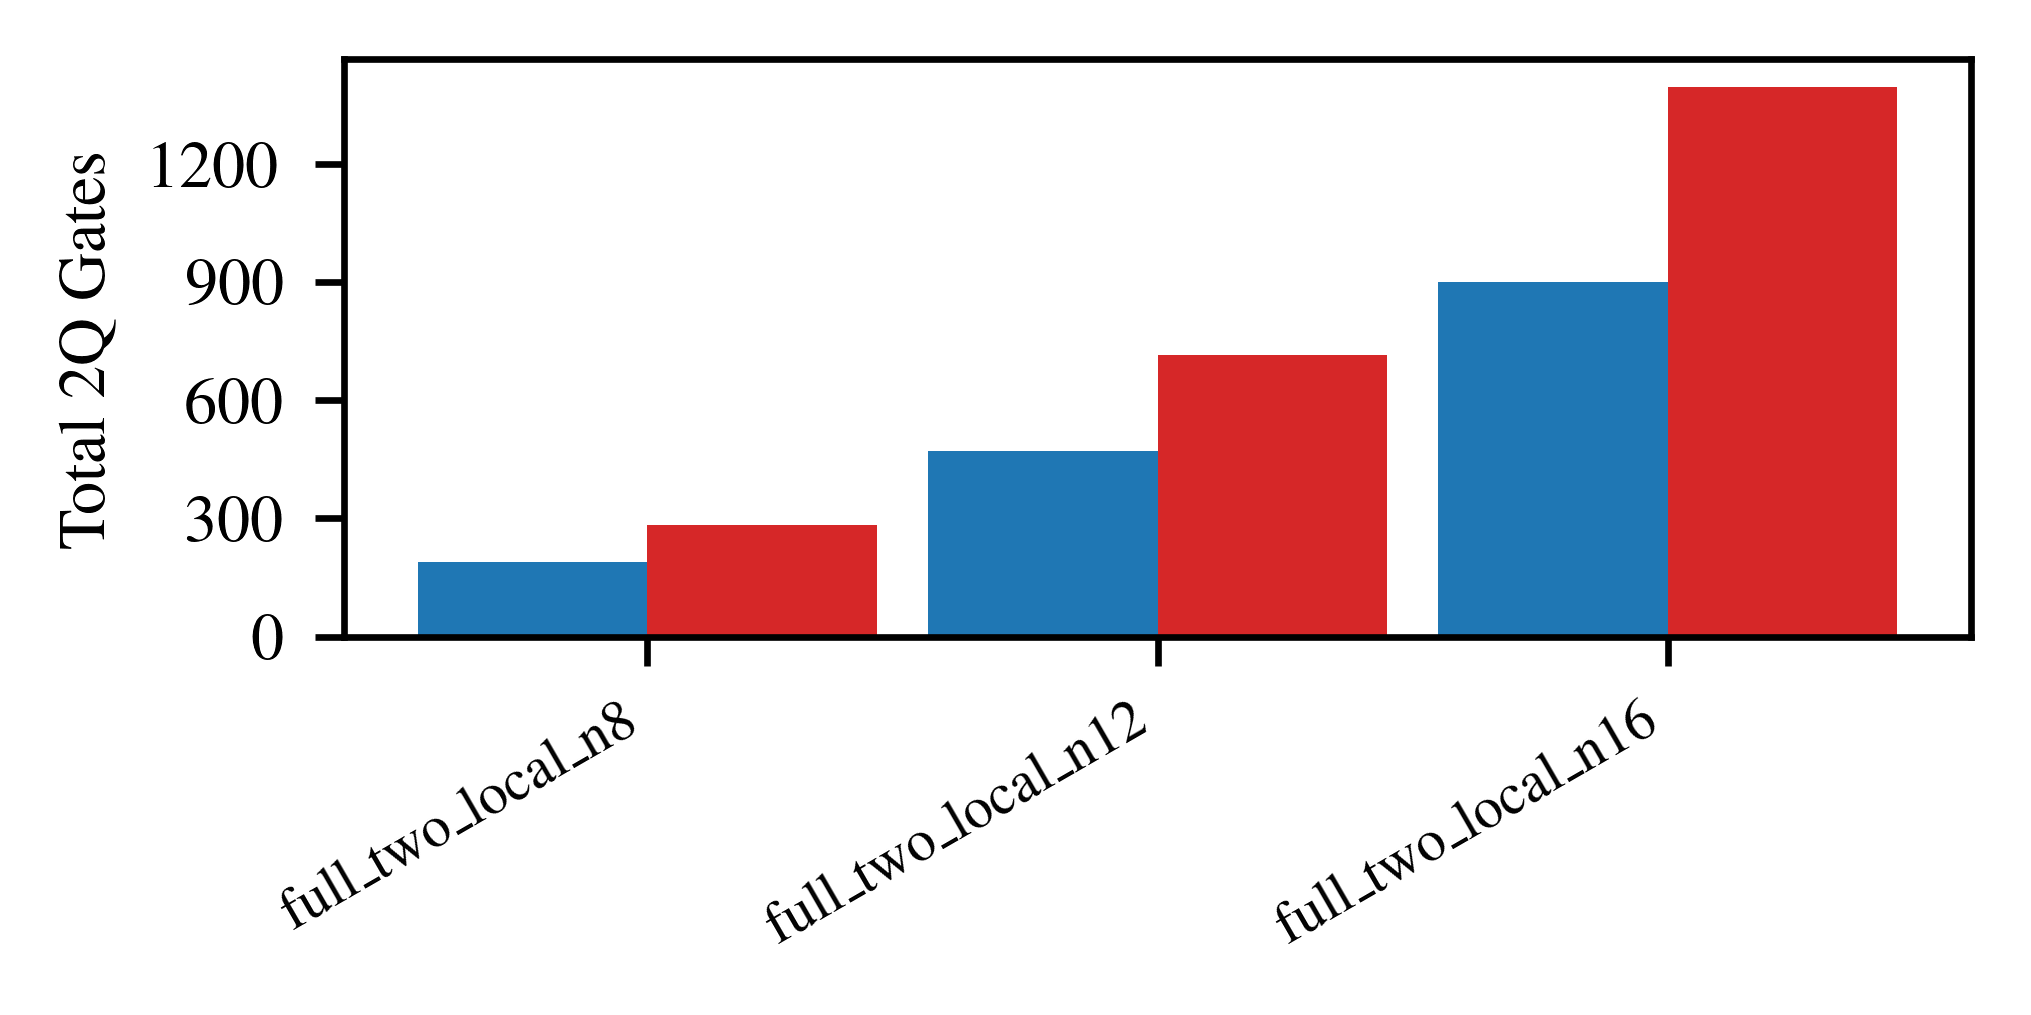

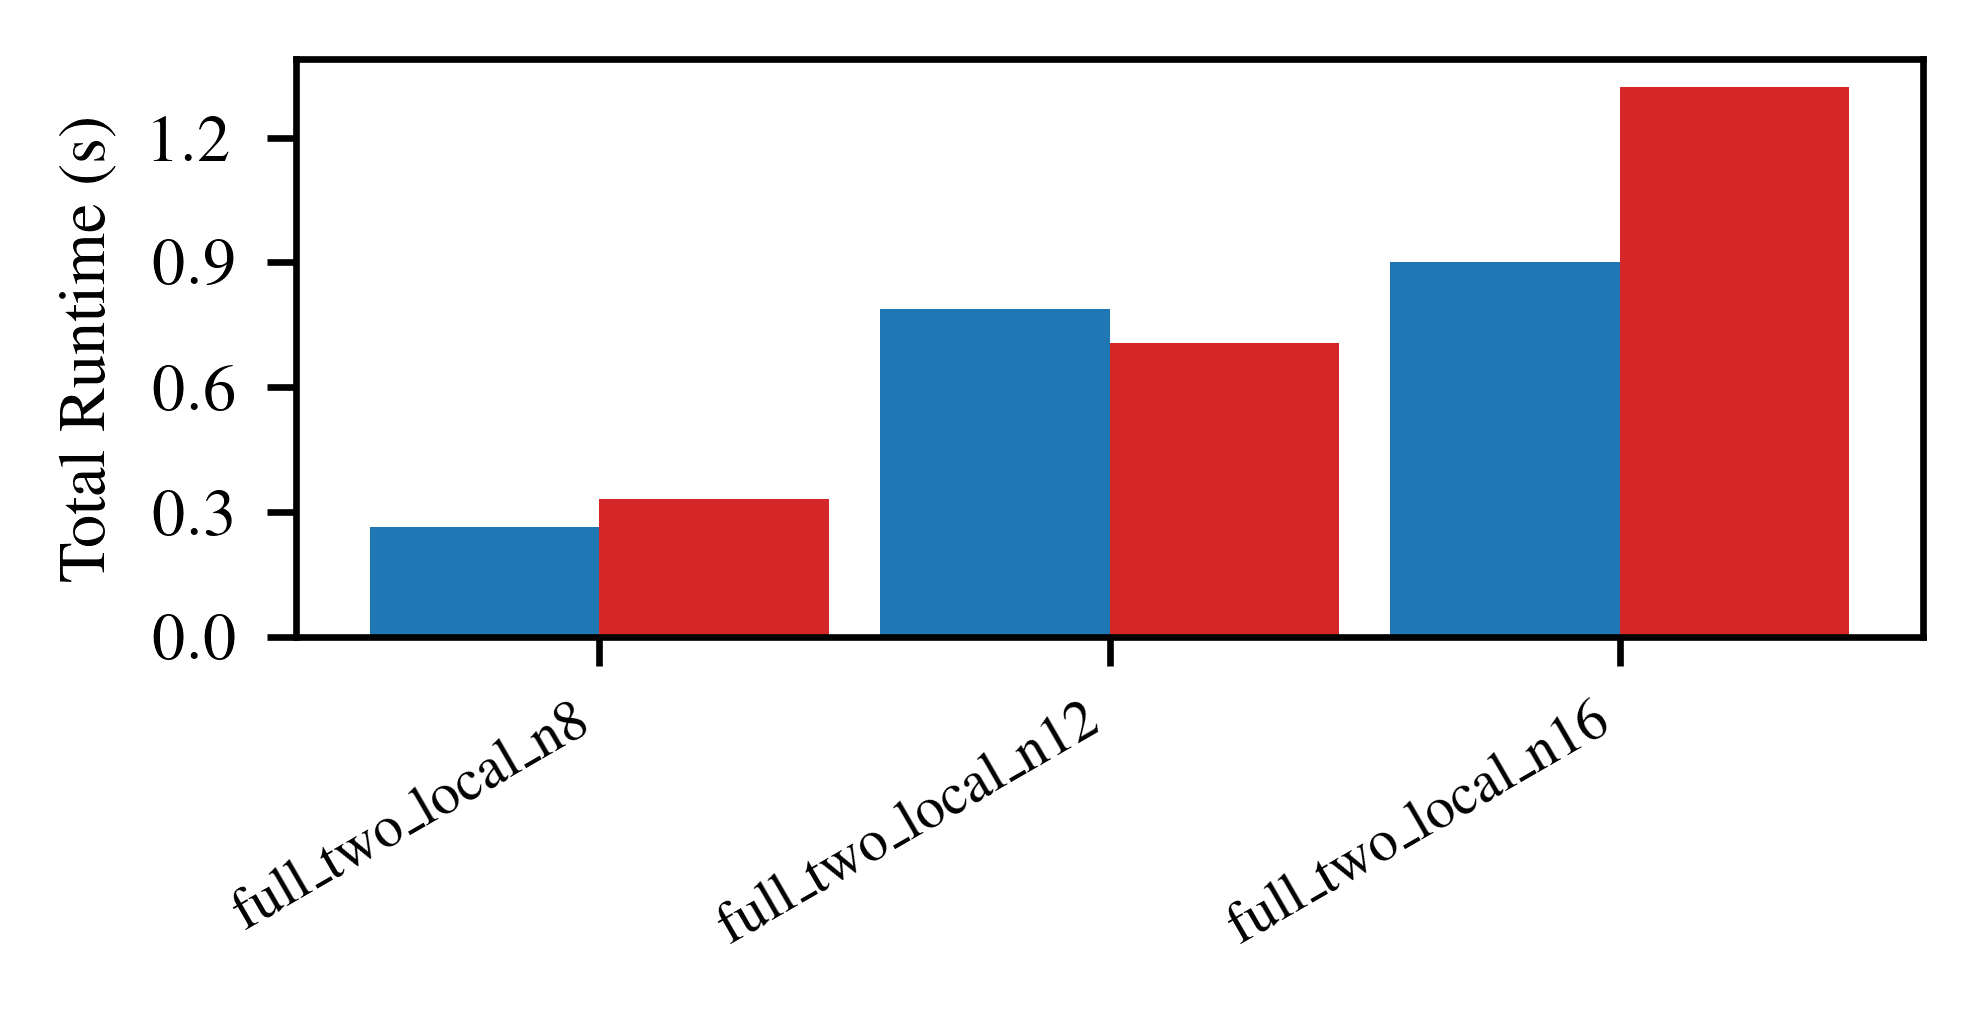

In [10]:
from transpile_benchy.render import plot_benchmark

plot_benchmark(benchmark, save=0, legend_show=1, filename="grid", color_override=[0, 3])